Transform and Roll Out
==========================

We will finally put everything together in this notebook to implement the famious Transformer model.

## Helper Files
Download these files and place them in the same directory as the current notebook before you start. 

In [160]:
from IPython.display import FileLink, FileLinks

In [163]:
FileLink('plots_transformer.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\transformer\plots_transformer.py

In [164]:
FileLink('util.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\transformer\util.py

In [165]:
FileLink('replay.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\transformer\replay.py

## Imports

In [132]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from plots_transformer import *
from util import *

We need `PositionalEncoding`, `subsequent_mask` and `EncoderDecoderSelfAttn` that we built earlier. They are copied here for clarity and completeness, and demonstrating when they are needed, but for better software engineering, you should consider putting them in a separate .py file, so they can be imported. 

## Narrow Attention

![](../images/attn_narrow_first_head.png)

### Multiheaded Attention

In [133]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = int(d_model / n_heads)
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.alphas = None

    def make_chunks(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # N, L, D -> N, L, n_heads * d_k
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k) 
        # N, n_heads, L, d_k
        x = x.transpose(1, 2)  
        return x

    def init_keys(self, key):
        # N, n_heads, L, d_k
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))
        
    def score_function(self, query):
        # scaled dot product
        # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
        proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(proj_query, 
                                    self.proj_key.transpose(-2, -1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def attn(self, query, mask=None):
        # Query is batch-first: N, L, D
        # Score function will generate scores for each head
        scores = self.score_function(query) # N, n_heads, L, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, n_heads, L, L
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()
        
        # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
        context = torch.matmul(alphas, self.proj_value)
        return context        
                                
    def output_function(self, contexts):
        # N, L, D
        out = self.linear_out(contexts) # N, L, D
        return out
        
    def forward(self, query, mask=None):
        if mask is not None:
            # N, 1, L, L - every head uses the same mask
            mask = mask.unsqueeze(1)

        # N, n_heads, L, d_k
        context = self.attn(query, mask=mask)
        # N, L, n_heads, d_k
        context = context.transpose(1, 2).contiguous()
        # N, L, n_heads * d_k = N, L, d_model
        context = context.view(query.size(0), -1, self.d_model)        
        # N, L, d_model
        out = self.output_function(context)
        return out

In [134]:
dummy_points = torch.randn(16, 2, 4) # N, L, F
mha = MultiHeadedAttention(n_heads=2, d_model=4, dropout=0.0)
mha.init_keys(dummy_points)
out = mha(dummy_points) # N, L, D
out.shape

torch.Size([16, 2, 4])

## Stacking Encoders and Decoders

The output of one encoder feeds the next, and the last encoder outputs states as
usual. These states will feed the cross-attention mechanism of all stacked decoders. The output of one decoder feeds the next, and the last decoder outputs
predictions as usual.

The former encoder is now a so-called "layer", and a stack of "layers" compose the
new, deeper, encoder. The same holds true for the decoder. Moreover, each
operation (multi-headed self- and cross-attention mechanisms and feed-forward
networks) inside a "layer" is now a "sub-layer".

![](../images/stacked_encdec.png)

![](../images/stacked_layers.png)

## Wrapping "Sub-Layers"

As our models grows deeper with many stacked "layers", we are running into
familiar issues, like the vanishing gradients problem.  we can add
batch and layer normalization, residual connections, introduce dropout to our model. We can wrap each and every "sub-layer" with them in either a norm-first or norm-last manner.

![](../images/sublayer.png)

$$
\Large
\begin{aligned}
&outputs_{norm-last}=&norm(inputs + dropout(sublayer(inputs))
\\
&outputs_{norm-first}=&inputs + dropout(sublayer(norm(inputs)))
\end{aligned}
$$

## Transformer Encoder

![](../images/enc_both.png)

$$
\large
\begin{aligned}
&outputs_{norm-last}=&norm(\underbrace{norm(inputs + att(inputs))}_{Output\ of\ SubLayer_0} + ffn(\underbrace{norm(inputs + att(inputs))}_{Output\ of\ SubLayer_0}))
\\
\\
&outputs_{norm-first}=&\underbrace{inputs + att(norm(inputs))}_{Output\ of\ SubLayer_0}+ffn(norm(\underbrace{inputs + att(norm(inputs))}_{Output\ of\ SubLayer_0}))
\end{aligned}
$$

In [135]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
         
    def forward(self, query, mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Multi-headed Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, mask)
        # Add
        att = query + self.drop1(states)
        
        # Sublayer #1
        # Norm
        norm_att = self.norm2(att)
        # Feed Forward
        out = self.ffn(norm_att)
        # Add
        out = att + self.drop2(out)
        return out

In [136]:
class EncoderTransf(nn.Module):
    def __init__(self, encoder_layer, n_layers=1, max_len=100):
        super().__init__()
        self.d_model = encoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer)
                                     for _ in range(n_layers)])
    
    def forward(self, query, mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, mask)
        # Norm
        return self.norm(x)

In [137]:
enclayer = nn.TransformerEncoderLayer(d_model=6, nhead=3, dim_feedforward=20)
enctransf = nn.TransformerEncoder(enclayer, num_layers=1, norm=nn.LayerNorm)

## Transformer Decoder

![](../images/dec_both.png)

In [138]:
class DecoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.cross_attn_heads = MultiHeadedAttention(n_heads, d_model,
                                                     dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.drop3 = nn.Dropout(dropout)
                
    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)
         
    def forward(self, query, source_mask=None, target_mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Masked Multi-head Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, target_mask)
        # Add
        att1 = query + self.drop1(states)
        
        # Sublayer #1
        # Norm
        norm_att1 = self.norm2(att1)
        # Multi-head Attention
        encoder_states = self.cross_attn_heads(norm_att1, source_mask)
        # Add
        att2 = att1 + self.drop2(encoder_states)
        
        # Sublayer #2
        # Norm
        norm_att2 = self.norm3(att2)
        # Feed Forward
        out = self.ffn(norm_att2)
        # Add
        out = att2 + self.drop3(out)
        return out

In [139]:
class DecoderTransf(nn.Module):
    def __init__(self, decoder_layer, n_layers=1, max_len=100):
        super(DecoderTransf, self).__init__()
        self.d_model = decoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer)
                                     for _ in range(n_layers)])
        
    def init_keys(self, states):
        for layer in self.layers:
            layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, source_mask, target_mask)
        # Norm
        return self.norm(x)

In [140]:
declayer = nn.TransformerDecoderLayer(d_model=6, nhead=3, dim_feedforward=20)
dectransf = nn.TransformerDecoder(declayer, num_layers=1, norm=nn.LayerNorm)

## The Transformer

![](../images/full_transformer.png)

The Transformer still is an encoder-decoder architecture like the one we
developed in the previous chapter, so it should be no surprise that we can actually
use our former `EncoderDecoderSelfAttn` class as a parent class and add two extra
components to it:
- a projection layer to map our original features (`n_features`) to the
dimensionality of both encoder and decoder (`d_model`)
- a final linear layer to map the decoder's outputs back to the original feature
space (the coordinates we’re trying to predict)

In [141]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super(EncoderDecoderSelfAttn, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subseque_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subseque_mask
                
    def encode(self, source_seq, source_mask):
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        outputs = self.decoder(shifted_target_seq, 
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs
    
    def predict(self, source_seq, source_mask):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X).bool()
        source_seq = X[:, :self.input_len, :]

        self.encode(source_seq, source_mask)
        if self.training:
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

In [142]:
class EncoderDecoderTransf(EncoderDecoderSelfAttn):
    def __init__(self, encoder, decoder, input_len, target_len, n_features):
        super(EncoderDecoderTransf, self).__init__(encoder, decoder, input_len, target_len)
        self.n_features = n_features
        self.proj = nn.Linear(n_features, encoder.d_model)
        self.linear = nn.Linear(encoder.d_model, n_features)
            
    def encode(self, source_seq, source_mask=None):
        # Projection
        source_proj = self.proj(source_seq)
        encoder_states = self.encoder(source_proj, source_mask)
        self.decoder.init_keys(encoder_states)    
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Projection
        target_proj = self.proj(shifted_target_seq)
        outputs = self.decoder(target_proj,
                               source_mask=source_mask,
                               target_mask=target_mask)
        # Linear
        outputs = self.linear(outputs)
        return outputs

### Data Preparation

In [143]:
def generate_sequences(n=128, variable_len=False, seed=13):
    basic_corners = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])
    np.random.seed(seed)
    bases = np.random.randint(4, size=n)
    if variable_len:
        lengths = np.random.randint(3, size=n) + 2
    else:
        lengths = [4] * n
    directions = np.random.randint(2, size=n)
    points = [basic_corners[[(b + i) % 4 for i in range(4)]][slice(None, None, d*2-1)][:l] + np.random.randn(l, 2) * 0.1 for b, d, l in zip(bases, directions, lengths)]
    return points, directions

In [144]:
# Generating training data
points, directions = generate_sequences()
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
# Generating test data
test_points, test_directions = generate_sequences(seed=17)
full_test = torch.as_tensor(points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]
# Datasets and data loaders
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)
generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

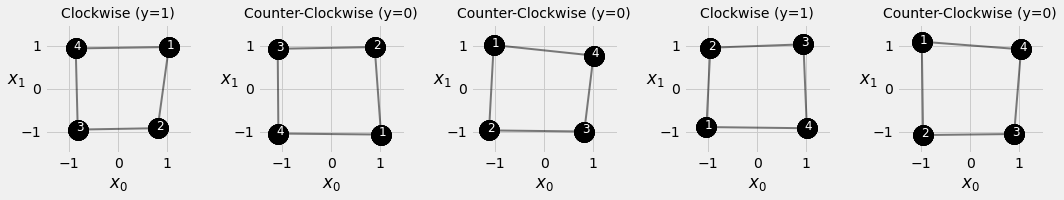

In [145]:
fig = plot_data(points, directions, n_rows=1)

### Model Configuration & Training

In [146]:
torch.manual_seed(42)
# Layers
enclayer = EncoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
declayer = DecoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
# Encoder and Decoder
enctransf = EncoderTransf(enclayer, n_layers=2)
dectransf = DecoderTransf(declayer, n_layers=2)
# Transformer
model_transf = EncoderDecoderTransf(enctransf, dectransf, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transf.parameters(), lr=0.01)

In [147]:
for p in model_transf.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [148]:
sbs_seq_transf = StepByStep(model_transf, loss, optimizer)
sbs_seq_transf.set_loaders(train_loader, test_loader)
sbs_seq_transf.train(50)

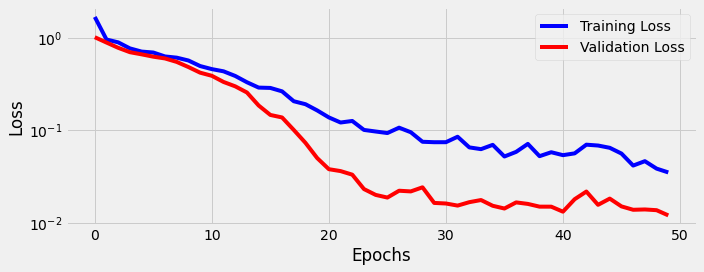

In [149]:
fig = sbs_seq_transf.plot_losses()

:::{note} Why is the validation loss so much better than the training loss?
This phenomenon may happen for a variety of reasons, from an easier validation set
to a "side effect" of regularization (e.g. dropout) in our current model. The
regularization makes it harder for the model to learn or, in other words, yields
higher losses. In our Transformer model, there are many dropout layers, so it gets
increasingly more difficult for the model to learn.
:::

Let's observe this effect by using the same mini-batch to compute the loss using
the trained model both in train and eval modes:

In [150]:
torch.manual_seed(11)
x, y = next(iter(train_loader))
device = sbs_seq_transf.device
# Training
model_transf.train()
loss(model_transf(x.to(device)), y.to(device))

tensor(0.0456, device='cuda:0', grad_fn=<MseLossBackward>)

In [151]:
# Validation
model_transf.eval()
loss(model_transf(x.to(device)), y.to(device))

tensor(0.0101, device='cuda:0')

The loss is roughly three times larger in training mode. 

:::{admonition} Your Turn
You can set dropout to zero and retrain the model to verify that both loss curves get
much closer to each other (by the way, the overall loss level gets better without
dropout, but that's just because our sequence-to-sequence problem is actually
quite simple).
:::

### Visualizing Predictions

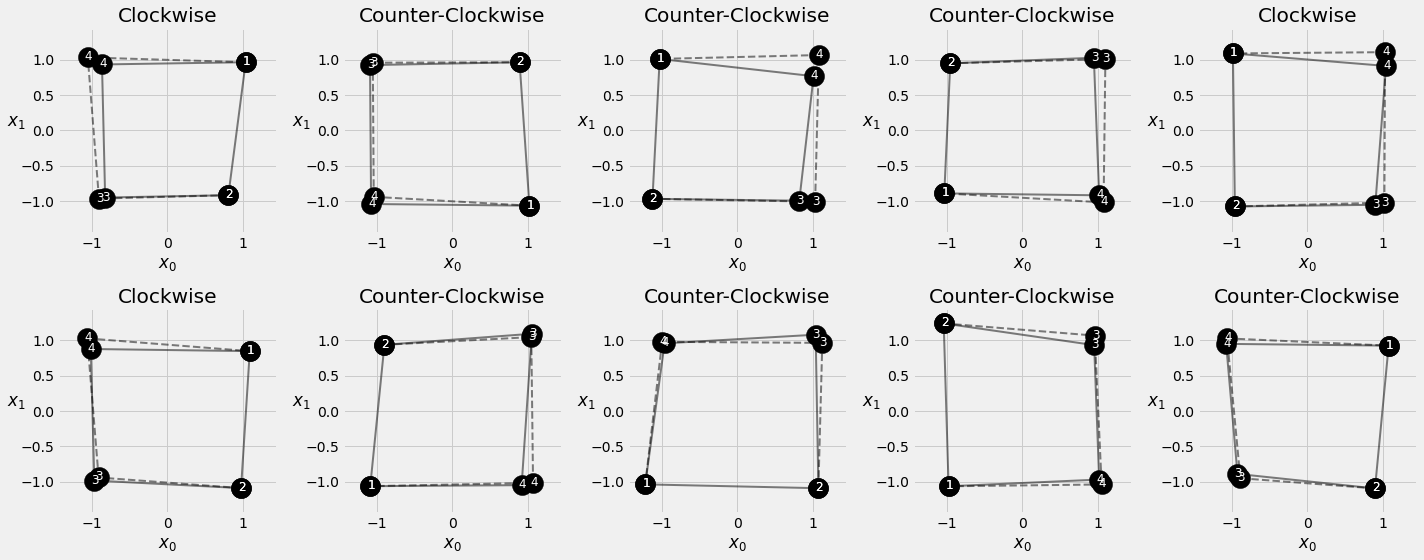

In [152]:
fig = sequence_pred(sbs_seq_transf, full_test, test_directions)

## The PyTorch Transformer

PyTorch implements a full-fledged Transformer class of its own:
`nn.Transformer`.

There are some differences between PyTorch's implementation and our own:
- first, and most importantly, PyTorch implements norm-last "sub-layer"
wrappers, normalizing the output of each "sub-layer"
- it does not implement positional encoding, the final linear layer, and the
projection layer, so we have to handle those ourselves.

The constructor expects many arguments because PyTorch's Transformer actually builds both encoder and decoder by itself.


![](../images/sublayer.png)

In [153]:
def encode_decode(self, source, target, source_mask=None, target_mask=None):
    # Projections
    # PyTorch Transformer expects L, N, F
    src = self.preprocess(source).permute(1, 0, 2)
    tgt = self.preprocess(target).permute(1, 0, 2)

    out = self.transf(src, tgt, 
                      src_key_padding_mask=source_mask, 
                      tgt_mask=target_mask)

    # Linear
    # Back to N, L, D
    out = out.permute(1, 0, 2)
    out = self.linear(out) # N, L, F
    return out

In [154]:
class TransformerModel(nn.Module):
    def __init__(self, transformer, input_len, target_len, n_features):
        super().__init__()
        self.transf = transformer
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.transf.generate_square_subsequent_mask(self.target_len)
        self.n_features = n_features
        self.proj = nn.Linear(n_features, self.transf.d_model)
        self.linear = nn.Linear(self.transf.d_model, n_features)
        
        max_len = max(self.input_len, self.target_len)
        self.pe = PositionalEncoding(max_len, self.transf.d_model)
        self.norm = nn.LayerNorm(self.transf.d_model)
                
    def preprocess(self, seq):
        seq_proj = self.proj(seq)
        seq_enc = self.pe(seq_proj)
        return self.norm(seq_enc)
    
    def encode_decode(self, source, target, source_mask=None, target_mask=None):
        # Projections
        # PyTorch Transformer expects L, N, F
        src = self.preprocess(source).permute(1, 0, 2)
        tgt = self.preprocess(target).permute(1, 0, 2)

        out = self.transf(src, tgt, 
                          src_key_padding_mask=source_mask, 
                          tgt_mask=target_mask)

        # Linear
        # Back to N, L, D
        out = out.permute(1, 0, 2)
        out = self.linear(out) # N, L, F
        return out
        
    def predict(self, source_seq, source_mask=None):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.encode_decode(source_seq, inputs, 
                                     source_mask=source_mask,
                                     target_mask=self.trg_masks[:i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = out[:, 1:, :]
        return outputs
        
    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X)
        source_seq = X[:, :self.input_len, :]
        
        if self.training:            
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.encode_decode(source_seq, shifted_target_seq, 
                                         source_mask=source_mask, 
                                         target_mask=self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### Model Configuration & Training

In [155]:
torch.manual_seed(42)
transformer = nn.Transformer(d_model=6, nhead=3, 
                             num_encoder_layers=1, num_decoder_layers=1,
                             dim_feedforward=20, dropout=0.1)
model_transformer = TransformerModel(transformer, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.01)

In [156]:
for p in model_transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [157]:
sbs_seq_transformer = StepByStep(model_transformer, loss, optimizer)
sbs_seq_transformer.set_loaders(train_loader, test_loader)
sbs_seq_transformer.train(50)

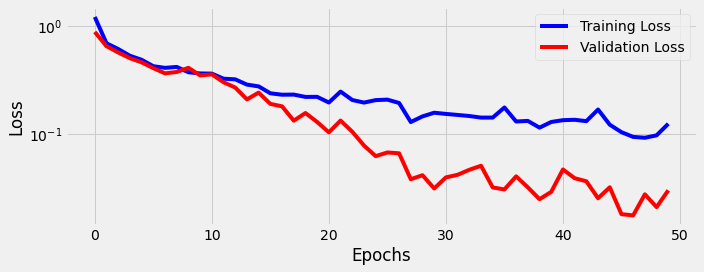

In [158]:
fig = sbs_seq_transformer.plot_losses()

### Visualizing Predictions

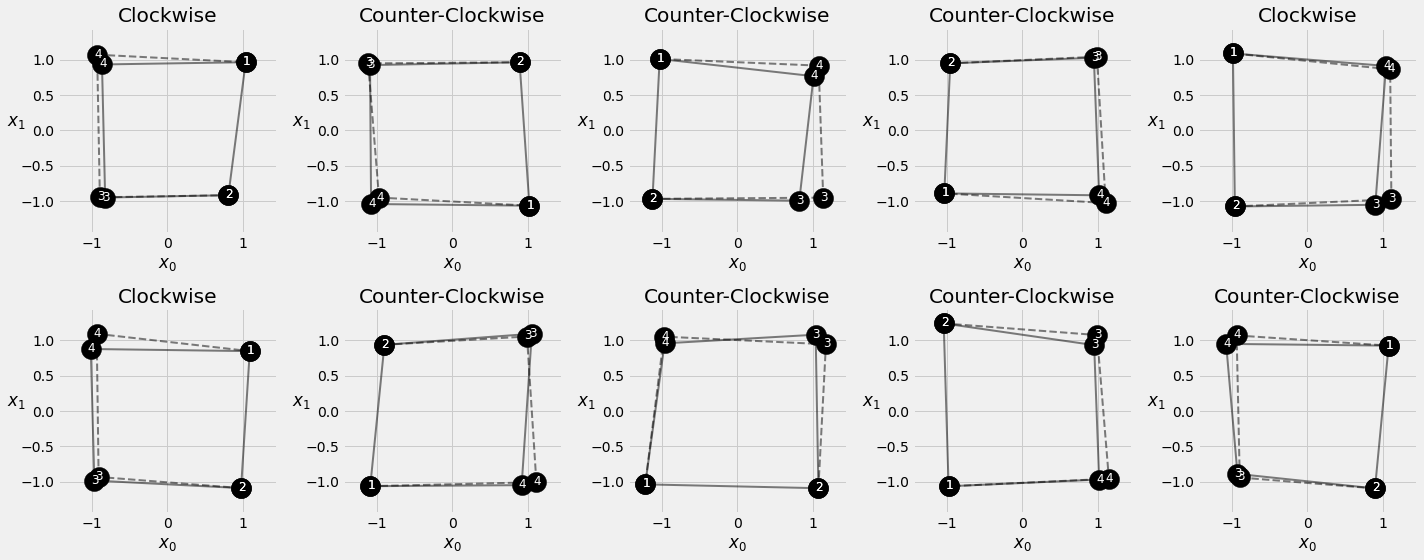

In [159]:
fig = sequence_pred(sbs_seq_transformer, full_test, test_directions)